# Leveraging LangChain to Build a Multi-Document Querying Application

We'll be building off the following diagram off the following diagram!

While it may look a bit complicated, we'll be tackling each piece individually!

Let's dig in!

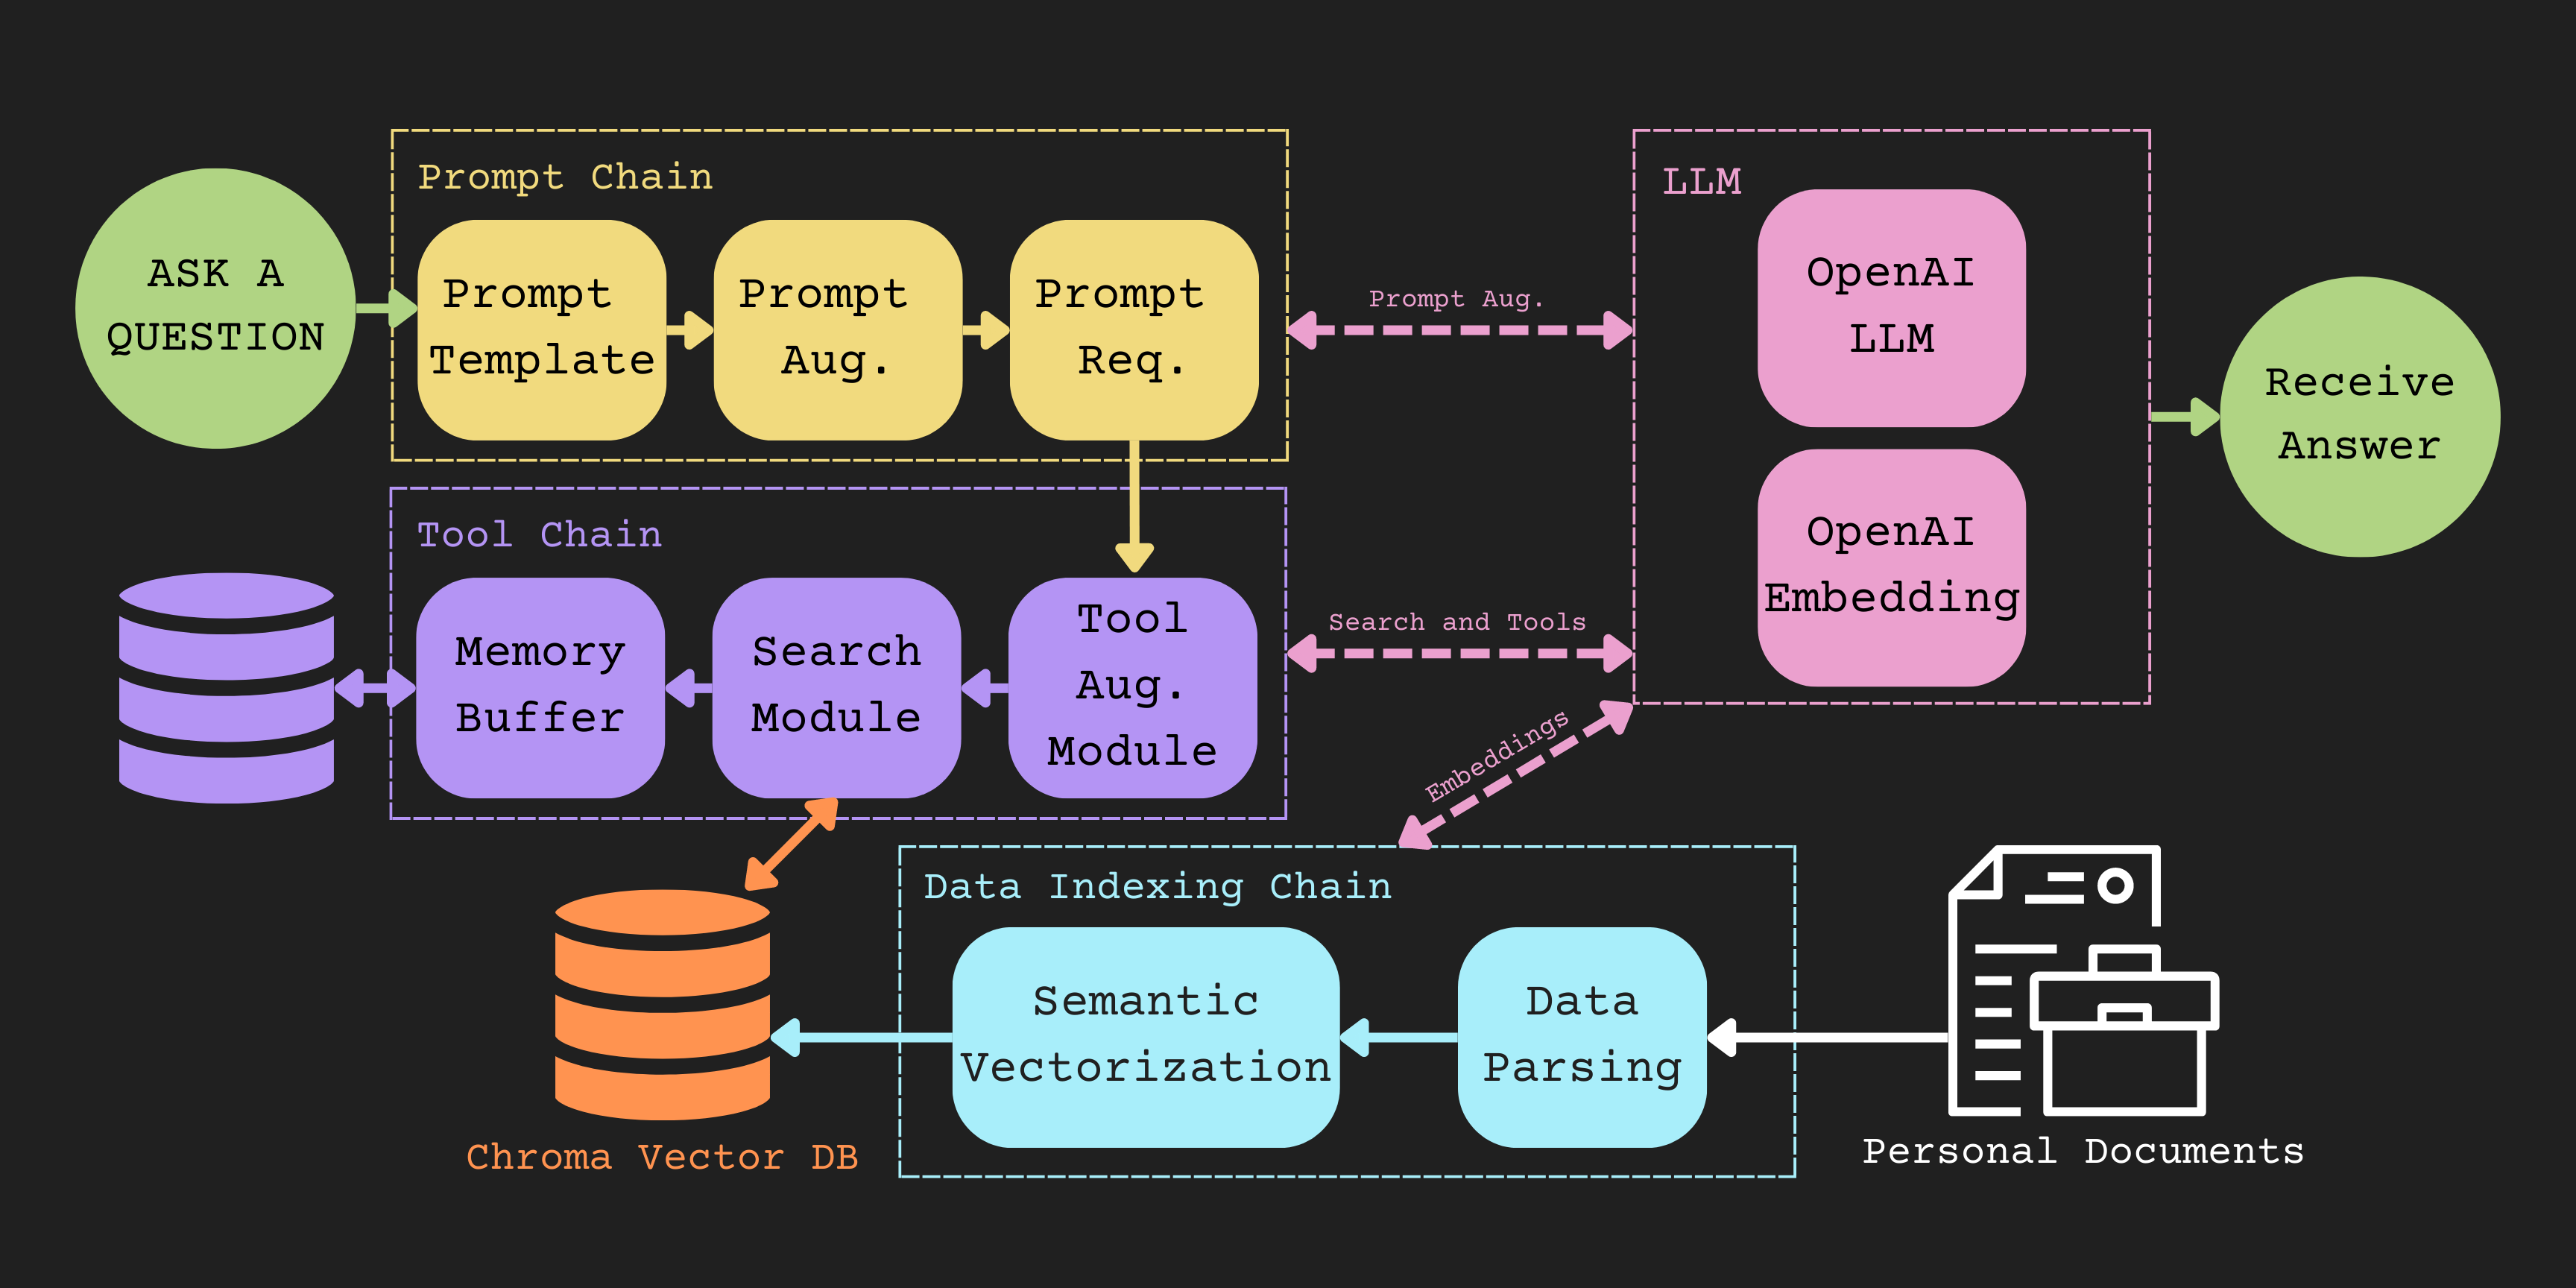

In [ ]:
!pip install openai langchain -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.0 MB/s eta 0:00:00


### Loading Source Data

We'll be focusing on this section of the diagram for our data.

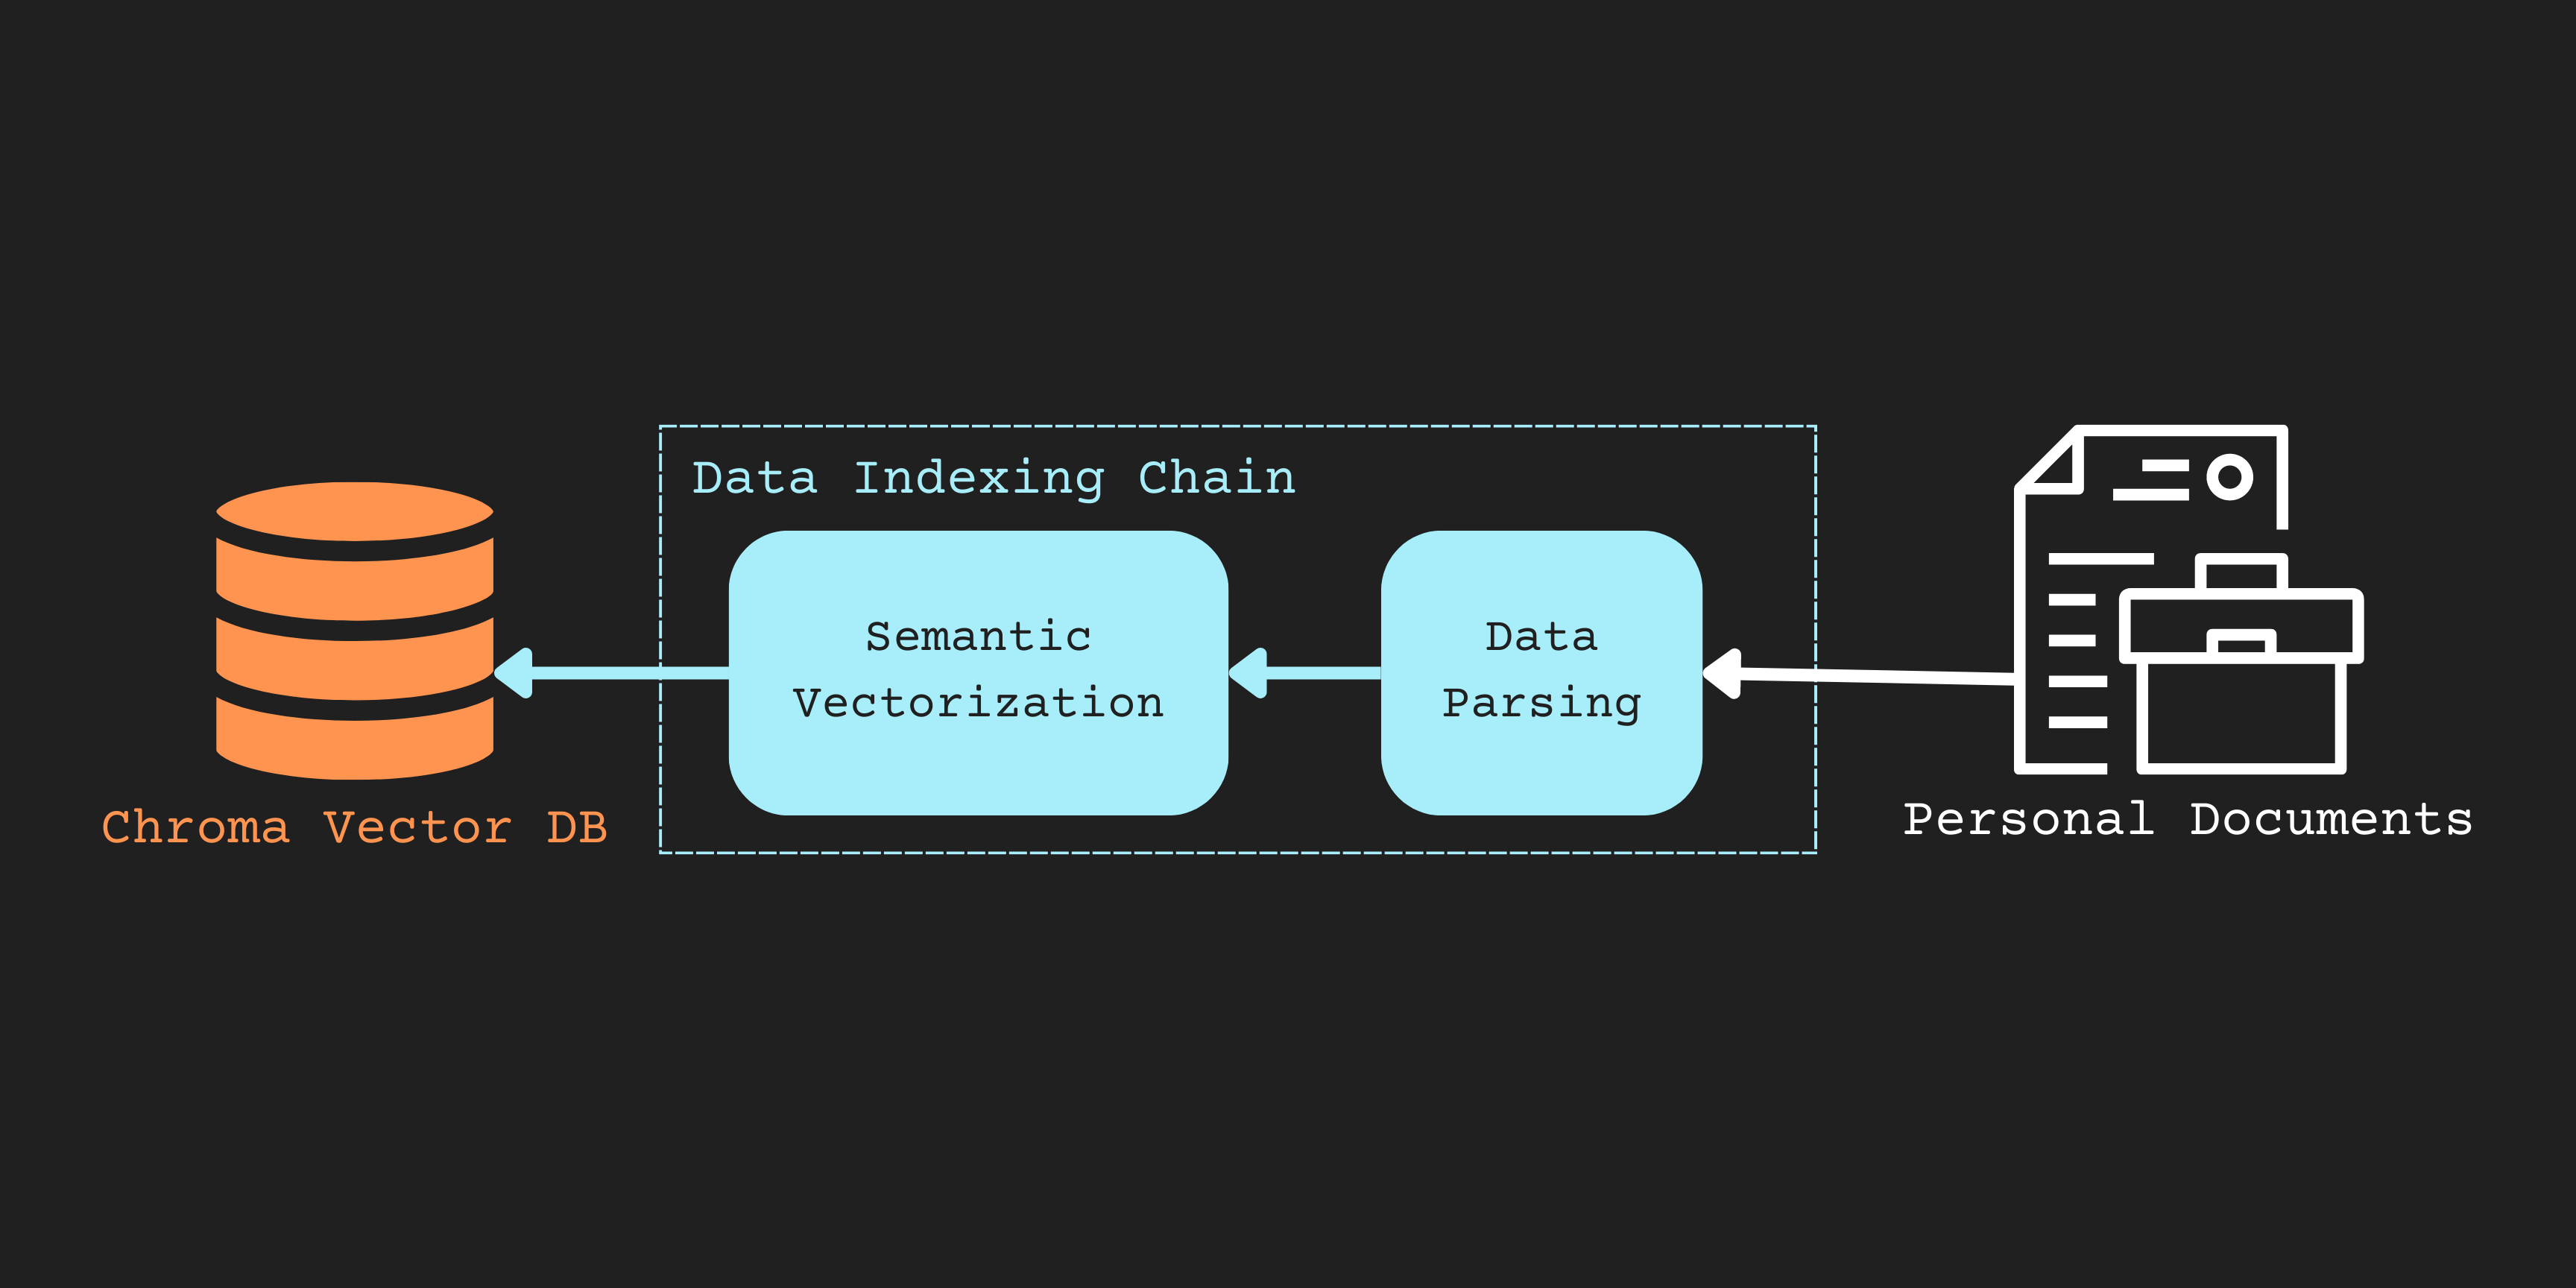

In order to get started, we'll first need a number of documents that we want to collect and manage.

To start us off, we'll be loading in the Alice in Wonderland series as well as some additional supplemental documents.

Let's get downloading!

> Please Note: Before you download this material, please ensure you check your local countries rules and regulations to ensure you're allowed to download the works of Lewis Carrol.





In [ ]:
!wget http://homepage.cs.uiowa.edu/~sriram/30/fall03/project1/alice.txt -O "Alice_1.txt"

--2023-07-10 22:57:00--  http://homepage.cs.uiowa.edu/~sriram/30/fall03/project1/alice.txt
Resolving homepage.cs.uiowa.edu (homepage.cs.uiowa.edu)... 128.255.96.133, 2620:0:e50:6810::80ff:6085
Connecting to homepage.cs.uiowa.edu (homepage.cs.uiowa.edu)|128.255.96.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148544 (145K) [text/plain]
Saving to: ‘Alice_1.txt’

Alice_1.txt         100%[===================>] 145.06K   894KB/s    in 0.2s    

2023-07-10 22:57:00 (894 KB/s) - ‘Alice_1.txt’ saved [148544/148544]



In [ ]:
!wget https://www.gutenberg.org/files/12/12-h/12-h.htm -O "Alice_2.htm"

--2023-07-10 22:57:02--  https://www.gutenberg.org/files/12/12-h/12-h.htm
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222038 (217K) [text/html]
Saving to: ‘Alice_2.htm’

Alice_2.htm         100%[===================>] 216.83K  1.00MB/s    in 0.2s    

2023-07-10 22:57:03 (1.00 MB/s) - ‘Alice_2.htm’ saved [222038/222038]



In [ ]:
!wget https://llds.ling-phil.ox.ac.uk/llds/xmlui/bitstream/handle/20.500.14106/1474/snark11-1474.txt?isAllowed=True -O "Alice_3.txt"

--2023-07-10 22:57:05--  https://llds.ling-phil.ox.ac.uk/llds/xmlui/bitstream/handle/20.500.14106/1474/snark11-1474.txt?isAllowed=True
Resolving llds.ling-phil.ox.ac.uk (llds.ling-phil.ox.ac.uk)... 163.1.86.107
Connecting to llds.ling-phil.ox.ac.uk (llds.ling-phil.ox.ac.uk)|163.1.86.107|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 32652 (32K) [text/plain]
Saving to: ‘Alice_3.txt’

Alice_3.txt         100%[===================>]  31.89K  --.-KB/s    in 0.1s    

2023-07-10 22:57:07 (232 KB/s) - ‘Alice_3.txt’ saved [32652/32652]



In [ ]:
!wget https://www.gutenberg.org/files/11/11-h/11-h.htm -O "Alice_4.htm"

--2023-07-10 22:57:08--  https://www.gutenberg.org/files/11/11-h/11-h.htm
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206966 (202K) [text/html]
Saving to: ‘Alice_4.htm’

Alice_4.htm         100%[===================>] 202.12K  1.09MB/s    in 0.2s    

2023-07-10 22:57:09 (1.09 MB/s) - ‘Alice_4.htm’ saved [206966/206966]



Now let's sort the various file extensions into their own folder so we can leverage our `DirectoryLoader` later on!

In [ ]:
from glob import glob

files = glob("*")

In [ ]:
import shutil
import os

os.mkdir('./data')

for individual_file in files:
  if individual_file.find(".") == -1:
    continue
  file_extension = individual_file.split(".")[-1]
  if not os.path.exists("./data/" + file_extension):
    os.mkdir("./data/" + file_extension)
  shutil.move(individual_file, "./data/" + file_extension)

While we'll be using this collection of HTML documents for the remainder of this example - you could use any collection of data that you wanted!

Have a look at [this link](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html) to see the full number of `DocumentLoader`s available.

Now that we have our documents downloaded, let's load them with a combination of `DirectoryLoader` and `BSHTMLLoader`, which is the BeautifulSoup4 powered `HTMLLoader`. We're using this to give us a bit more metadata for our documents.

In [ ]:
# install dependencies
!pip install beautifulsoup4 -q

In [ ]:
from langchain.document_loaders import BSHTMLLoader, DirectoryLoader

bshtml_dir_loader = DirectoryLoader('./data/htm', loader_cls=BSHTMLLoader)

data = bshtml_dir_loader.load()

Now that we have our data loaded (with additional metadata thanks to the `BSHTMLLoader`), we can move onto splitting those documents into appropriately sized pieces!

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
)

documents = text_splitter.split_documents(data)

Now that we have our documents split - we need to convert them into embeddings!

First up, we'll set-up our OpenAI API key!

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = ""

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

Now we can embed our chunked documents into a ChromaVectorDB!

We are going to be going through the example of persisting this particular DB - but we won't be leveraging the persisted version.

For the example, we just want to showcase how you would persist this particular VectorDB.

You'll notice that there is some GPU usage during this process - since we're leveraging Sentence Transformers to do our embeddings.

It will also take some time, for that same reason.

In [ ]:
# we'll need a few dependencies before we can do this
!pip install chromadb tiktoken -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.1/965.1 kB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.6 MB/s 

In [ ]:
from langchain.vectorstores import Chroma

persist_directory = "vector_db"

vectordb = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=persist_directory)

Now we can persist our Chroma vector store - and then show an example of how you would load that persisted vector store.

In [ ]:
vectordb.persist()
vectordb = None

As you can see when you run the following cell - loaded the persisted vectore store is *much* quicker than reinstantiating it - and that is the benefit of `persist_directory`!

In [ ]:
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

Now, if you were paying close attention you'll realize that we actually only added our `.htm` resources.

So how do we add additional resources to our already created vector database, we'll - let's find out!

First thing we'll need to do is collect our `.txt` documents into a loader and split them into similarly sized documents.

In [ ]:
from langchain.document_loaders import TextLoader, DirectoryLoader

txt_dir_loader = DirectoryLoader('./data/txt', loader_cls=TextLoader)

txt_data = txt_dir_loader.load()

We can resuse our `RecursiveCharacterSplitter` from above without issue.

In [ ]:
txt_documents = text_splitter.split_documents(txt_data)

Now, when we repeat the process to add documents to our Chroma vector databse, we should see the new documents added!

In [ ]:
vectordb = Chroma.from_documents(documents=txt_documents, embedding=embeddings, persist_directory=persist_directory)

In [ ]:
vectordb.similarity_search("rabbit")

[Document(page_content="The long grass rustled at her feet as the White Rabbit hurried\nby--the frightened Mouse splashed his way through the\nneighbouring pool--she could hear the rattle of the teacups as\nthe March Hare and his friends shared their never-ending meal,\nand the shrill voice of the Queen ordering off her unfortunate\nguests to execution--once more the pig-baby was sneezing on the\nDuchess's knee, while plates and dishes crashed around it--once\nmore the shriek of the Gryphon, the squeaking of the Lizard's\nslate-pencil, and the choking of the suppressed guinea-pigs,\nfilled the air, mixed up with the distant sobs of the miserable\nMock Turtle.", metadata={'source': 'data/txt/Alice_1.txt'}),
 Document(page_content='The long grass rustled at her feet as the White Rabbit hurried by—the\nfrightened Mouse splashed his way through the neighbouring pool—she could\nhear the rattle of the teacups as the March Hare and his friends shared their\nnever-ending meal, and the shrill v

As you can see, all of our sources are included in the vector database, and we're ready to move on to the next steps!

### Tool Chain

We'll be looking to leverage the entire LangChain suite combined with OpenAI to build a full application - with memory and all!

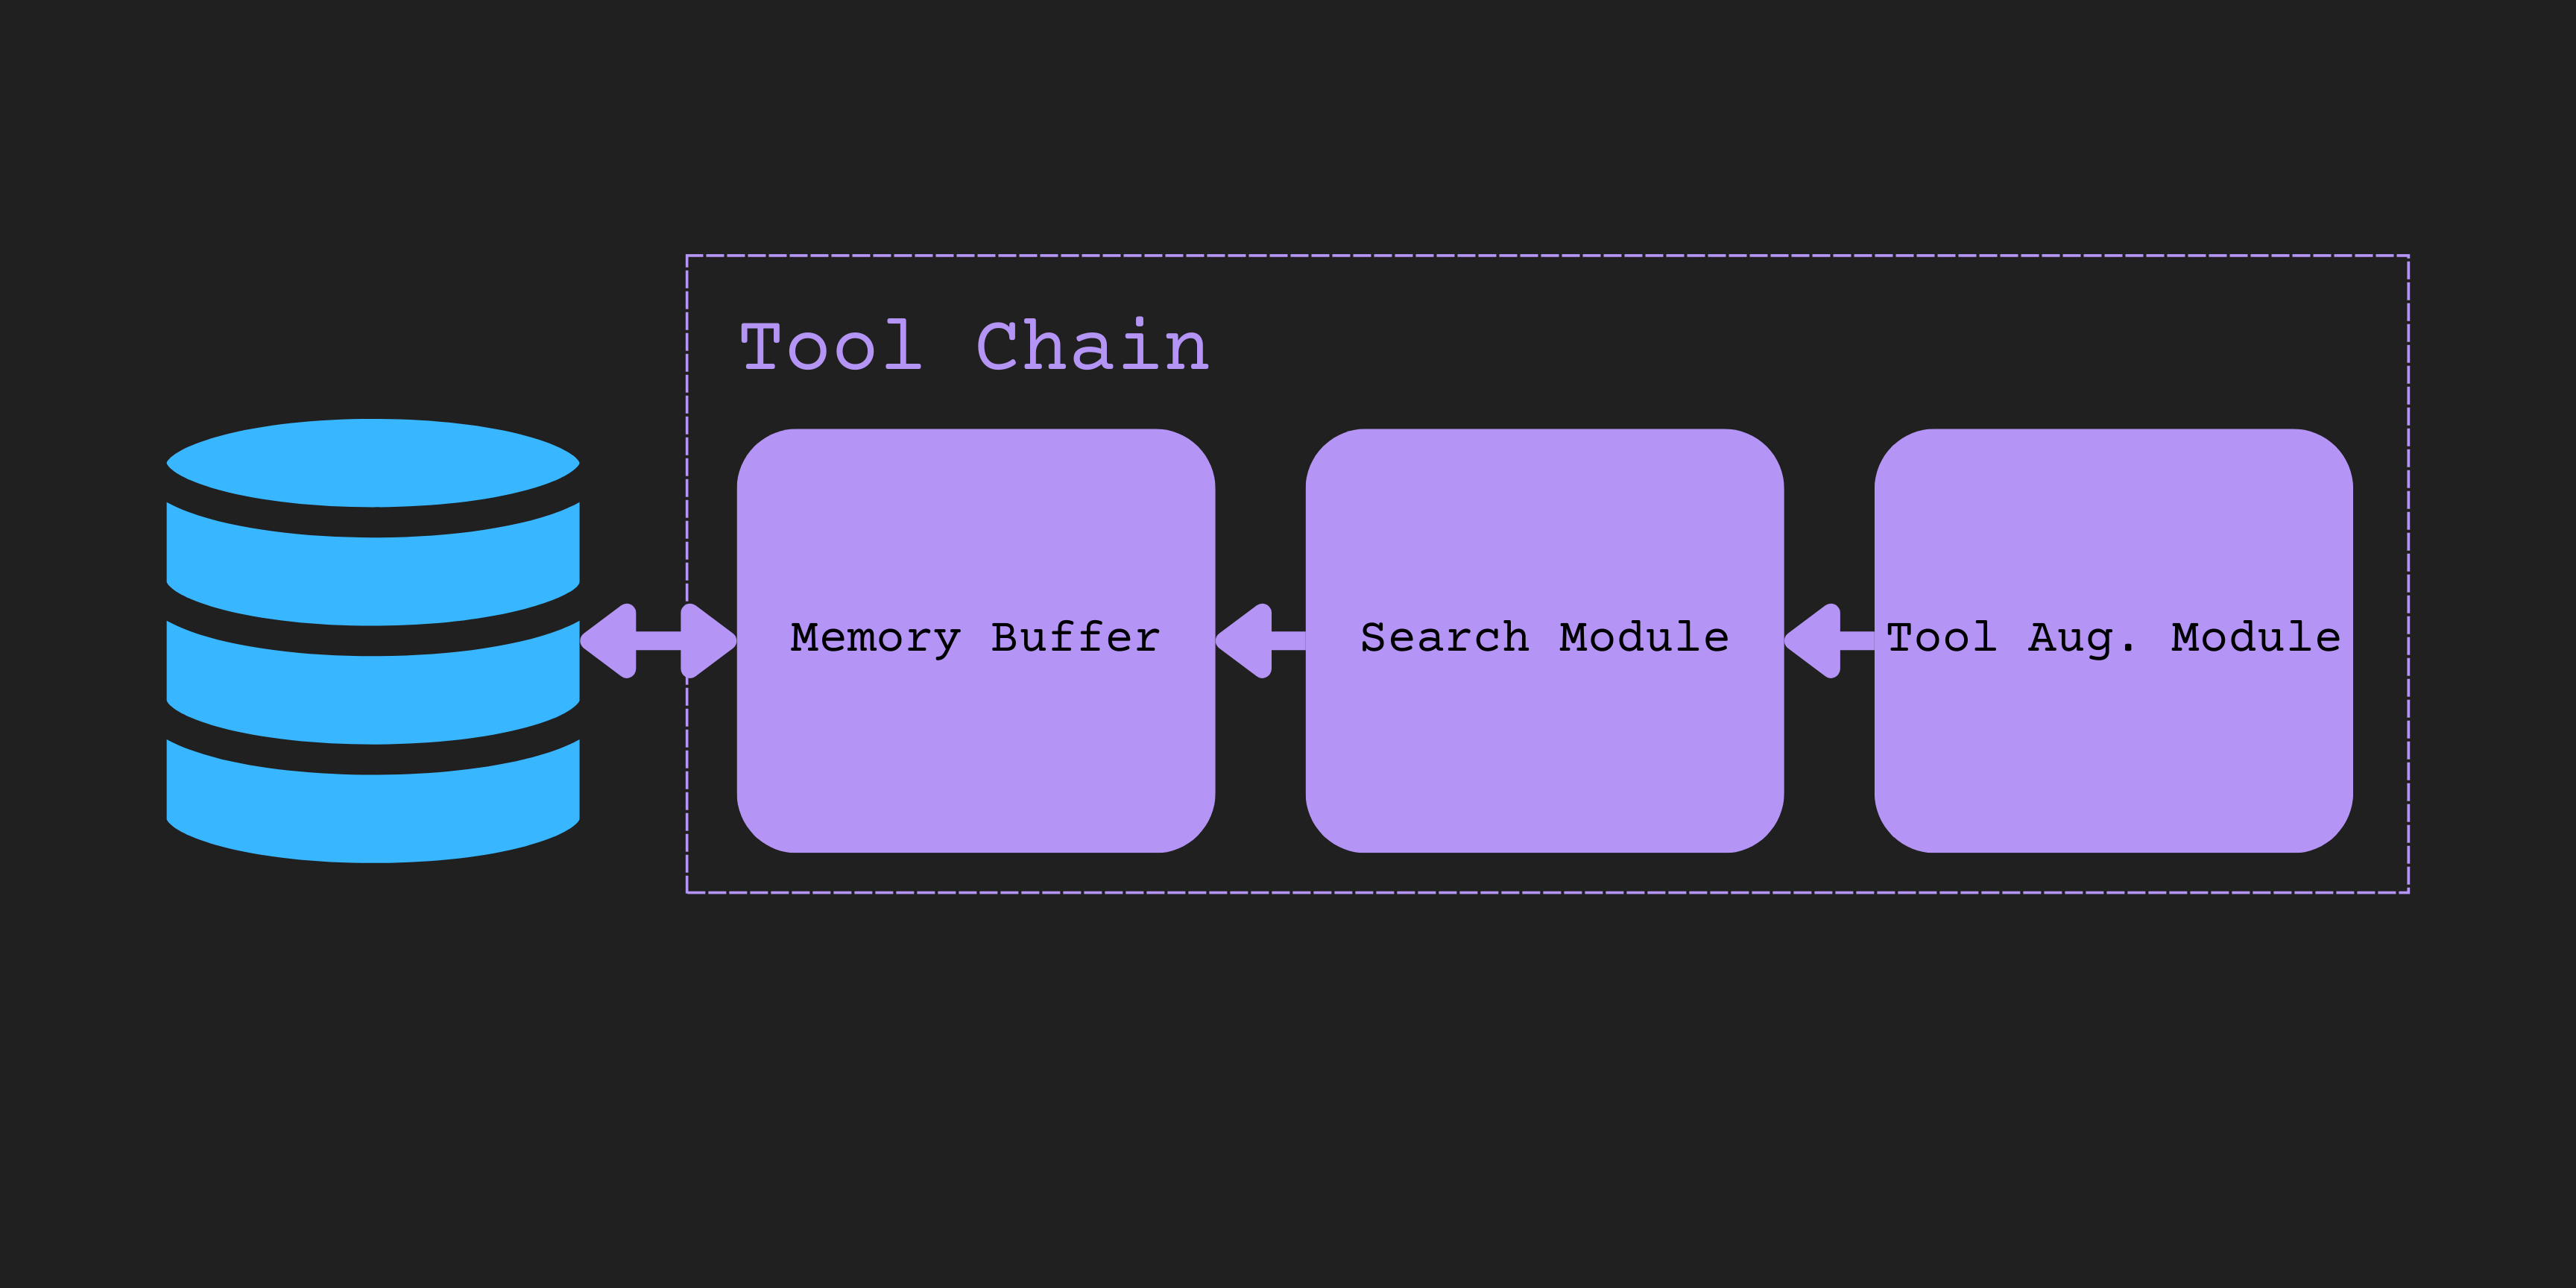


First up, let's load our model!

In [ ]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

Now let's set up our document vector store as a Retriever tool so we can leverage it in our chain!

In [ ]:
doc_retriever = vectordb.as_retriever()

With that set-up, we're good to set-up our RetrievalQA chain and leverage all the documents we have in our Vector DB!

In [ ]:
from langchain.chains import RetrievalQA

alice_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever)

Let's test it out by itself!

In [ ]:
alice_qa.run("What is up with the Cheshire Cat?")

"The Cheshire Cat is known for its constant grin. According to the Duchess, all Cheshire cats can grin, and most of them do. Alice didn't know that cats could grin, so she was surprised by it. The Cat only grinned when it saw Alice, and although it appeared friendly, Alice also noticed its long claws and many teeth, so she felt it should be treated with respect."

Now, let's set-up a search tool leveraging SERP API!

You can find the process to set this up [here](https://serpapi.com/)

In [ ]:
!pip install google-search-results -q

  Preparing metadata (setup.py) ... done


In [ ]:
os.environ["SERPAPI_API_KEY"] = ""

In [ ]:
from langchain.utilities import SerpAPIWrapper

search = SerpAPIWrapper()

Now we can combine those

In [ ]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import BaseTool
from langchain.llms import OpenAI
from langchain import SerpAPIWrapper

tools = [
    Tool(
        name = "Alice in Wonderland QA System",
        func=alice_qa.run,
        description="useful for when you need to answer questions about Alice in Wonderland. Input should be a fully formed question."
    ),
    Tool(
        name = "Backup Alice Google Search",
        func=search.run,
        description="useful for when you need to answer questions about Alice in Wonderland but only when the Alice in Wonderland QA System couldn't answer the query. Input should be a fully formed question."
    ),
]

In [ ]:
agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

In [ ]:
agent.run("What is the deal with the Cheshire Cat?")



> Entering new  chain...
I'm not sure about the specifics of the Cheshire Cat, but it sounds like a character from Alice in Wonderland.
Action: Alice in Wonderland QA System
Action Input: "What is the deal with the Cheshire Cat?"
Observation: The Cheshire Cat is a character in Alice's Adventures in Wonderland. It is known for its distinctive grin and ability to disappear and reappear at will. The Duchess explains to Alice that the cat is a Cheshire cat, which is why it grins. The cat also tells Alice that all cats can grin, but Alice is not aware of any cats that can. The Cheshire Cat is portrayed as mischievous and enigmatic, offering cryptic advice to Alice throughout her journey.
Thought:I now know the final answer
Final Answer: The Cheshire Cat is a mischievous and enigmatic character in Alice's Adventures in Wonderland known for its distinctive grin and ability to disappear and reappear at will.

> Finished chain.


"The Cheshire Cat is a mischievous and enigmatic character in Alice's Adventures in Wonderland known for its distinctive grin and ability to disappear and reappear at will."

Now, let's add some memory to our application!

In [ ]:
from langchain.memory import ConversationBufferMemory, ReadOnlySharedMemory

memory = ConversationBufferMemory(memory_key="chat_history")
readonlymemory = ReadOnlySharedMemory(memory=memory)

In order to let our Tools leverage the memory - we'll want to add the ability to read the memory to their chains!

In [ ]:
alice_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever, memory=readonlymemory)

Now we can re-create our Tools list - this time using the memory capable version of the `alice_qa` chain!

In [ ]:
tools = [
    Tool(
        name = "Alice in Wonderland QA System",
        func=alice_qa.run,
        description="useful for when you need to answer questions about Alice in Wonderland. Input should be a fully formed question."
    ),
    Tool(
        name = "Backup Alice Google Search",
        func=search.run,
        description="useful for when you need to answer questions about Alice in Wonderland but only when the Alice in Wonderland QA System couldn't answer the query. Input should be a fully formed question."
    ),
]

Let's now add some of the prompt pieces so our agent can respond exactly as we expect!

In [ ]:
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor

prefix = """Have a conversation with a human, answering the following questions as best you can. You have access to the following tools:"""
suffix = """Begin!"

{chat_history}
Question: {input}
{agent_scratchpad}"""

prompt = ZeroShotAgent.create_prompt(
    tools,
    prefix=prefix,
    suffix=suffix,
    input_variables=["input", "chat_history", "agent_scratchpad"]
)

Now let's add this prompt template to our OpenAI LLM!

In [ ]:
from langchain import OpenAI, LLMChain, PromptTemplate

llm_chain = LLMChain(llm=llm, prompt=prompt)

Now we can set up our final agent!

In [ ]:
agent = ZeroShotAgent(llm_chain=llm_chain, tools=tools, verbose=True)
agent_chain = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True, memory=memory)

Let's test this out!

In [ ]:
agent_chain.run(input="What is the deal with the Cheshire Cat?")



> Entering new  chain...
Thought: I'm not sure about the details of the Cheshire Cat in Alice in Wonderland.
Action: Alice in Wonderland QA System
Action Input: What is the deal with the Cheshire Cat?
Observation: The Cheshire Cat is a character in Alice's Adventures in Wonderland. It is known for its distinctive grin and ability to disappear and reappear at will. The Duchess explains to Alice that the cat is a Cheshire cat, which is why it grins. The cat also tells Alice that all cats can grin, but Alice is not aware of any cats that can. The Cheshire Cat is portrayed as mischievous and enigmatic, offering cryptic advice to Alice throughout her journey.
Thought:I now know the final answer
Final Answer: The Cheshire Cat is a mischievous and enigmatic character in Alice's Adventures in Wonderland known for its distinctive grin and ability to disappear and reappear at will.

> Finished chain.


"The Cheshire Cat is a mischievous and enigmatic character in Alice's Adventures in Wonderland known for its distinctive grin and ability to disappear and reappear at will."

In [ ]:
agent_chain.run(input="What makes it enigmatic?")



> Entering new  chain...
Thought: I'm not sure about the specific details that make the Cheshire Cat enigmatic.
Action: Alice in Wonderland QA System
Action Input: What makes the Cheshire Cat enigmatic?
Observation: The Cheshire Cat is enigmatic because it has the ability to grin and disappear, leaving only its smile behind. It also speaks in riddles and seems to have knowledge about the strange world of Wonderland. Its mysterious nature and unpredictable behavior make it an enigmatic character.
Thought:I now know the final answer.
Final Answer: The Cheshire Cat is enigmatic because of its ability to disappear, its riddles, and its knowledge of Wonderland.

> Finished chain.


'The Cheshire Cat is enigmatic because of its ability to disappear, its riddles, and its knowledge of Wonderland.'

In [ ]:
agent_chain.run(input="What are some of its riddles?")



> Entering new  chain...
Thought: I don't know the specific riddles the Cheshire Cat asks.
Action: Alice in Wonderland QA System
Action Input: What are some riddles asked by the Cheshire Cat?
Observation: There are no riddles specifically mentioned in the given context.
Thought:The Alice in Wonderland QA System couldn't answer the query.
Action: Backup Alice Google Search
Action Input: Riddles asked by the Cheshire Cat in Alice in Wonderland
Observation: Alice asked the Cheshire Cat, who was sitting in a tree, “What road do I take?” The cat asked, “Where do you want to go?” “I don't know,” Alice answered. “Then,” said the cat, “it really doesn't matter, does it?
Thought:I now know the final answer
Final Answer: One of the riddles asked by the Cheshire Cat is, "What road do I take?"

> Finished chain.


'One of the riddles asked by the Cheshire Cat is, "What road do I take?"'

In [ ]:
agent_chain.run(input="What is Alice's response to that riddle?")



> Entering new  chain...
Thought: I'm not sure about Alice's response to that riddle.
Action: Alice in Wonderland QA System
Action Input: What is Alice's response to the Cheshire Cat's riddle, "What road do I take?"
Observation: Alice's response to the Cheshire Cat's riddle, "What road do I take?" is, "I don't much care where-- so long as I get SOMEWHERE."
Thought:I now know the final answer.
Final Answer: Alice's response to the Cheshire Cat's riddle, "What road do I take?" is, "I don't much care where-- so long as I get SOMEWHERE."

> Finished chain.


'Alice\'s response to the Cheshire Cat\'s riddle, "What road do I take?" is, "I don\'t much care where-- so long as I get SOMEWHERE."'

### Pushing Small Vector Database to Hugging Face

Now that we have created our vector database, let's push it to a Hugging Face Space!

You'll first want to duplicate the [sample space](https://huggingface.co/spaces/ml-maker-space/AliceInWonderLandChainlit), then you can push your newly created Vector Database to your newly duplicated space!

In [ ]:
!pip install -U -q huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import HfApi

HF_USERNAME = "ml-maker-space"
HF_REPOSITORY_NAME = "AliceInWonderLandChainlit"

api = HfApi()

api.upload_folder(
    folder_path = "vector_db",
    path_in_repo = "vector_db",
    repo_id = f"{HF_USERNAME}/{HF_REPOSITORY_NAME}",
    repo_type="space"
)

'https://huggingface.co/spaces/c-s-ale/AliceInWonderlandChainlit/tree/main/vector_db'

### Conclusion

There we have it!

A fully functioning QA application *with* agent memory and external API fallback!